# BU7154 – Bank Marketing: Question 1 Two-Level Customer Segmentation
# 两层客户细分建模（客户背景 + 活动潜力）

**Business Goal / 业务目标：**  

Design a **two-level segmentation** that banking management can easily understand and act on.  
设计一套银行管理层**容易理解且可直接用于决策**的两层客户细分体系：  

1. **Level 1 – Customer Background Segments / 第一层：客户背景客群**  
   - Features: **Demographic + Financial & Risk**  
   - 问题：我们整体服务的是哪些人？在生命周期、职业、教育和财务实力上，有哪些主要客群？  

2. **Level 2 – Financial & Campaign Potential Segments / 第二层：财务实力 + 活动潜力客群**  
   - Features: **Financial & Risk + Campaign history**  
   - 问题：在同一背景客群中，哪些客户既有财务能力，又对当前营销活动（campaign）具有更高的转化潜力？  

最终我们会得到：  
- Level 1：3 个客户背景大类  
- Level 2：每个背景大类再细分为 2 个活动潜力子类（高潜 / 低潜），共 **6 个可行动客群**。  

---

**File paths used in this notebook / 本 notebook 使用的文件路径：**  

- Raw data / 原始数据：  
  `D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\bank-full.csv`  

- Notebook location (suggested) / 建议将本 Notebook 放在：  
  `D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\code`  

- Output files from modeling / 建模输出文件保存路径：  
  `D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output`

In [7]:
# 1. Import libraries / 导入所需库
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 200)
%matplotlib inline

In [8]:
# 2. Define file paths & load dataset / 定义文件路径并读取数据

data_path = r"D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\bank-full.csv"
output_dir = r"D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output"

os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(data_path, sep=";")
print("Shape of raw data / 原始数据维度:", df.shape)

df["customer_id"] = np.arange(1, len(df) + 1)
df.head()

Shape of raw data / 原始数据维度: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,customer_id
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,3
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,4
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,5


In [9]:
# 3. Basic data overview / 基本数据概览
df.info()
print("\nTarget y distribution / 目标变量 y 分布：")
print(df["y"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      45211 non-null  object
 9   day          45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     45211 non-null  object
 16  y            45211 non-null  object
 17  customer_id  45211 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 6.2+ MB

Target y distributi

## 4. Two-level feature design / 两层细分的特征设计

### Level 1 – Customer Background Segmentation / 第一层：客户背景细分

Features: Demographic + Financial & Risk  
特征：人口特征 + 财务与风险变量

- `age`, `job`, `marital`, `education`  
- `balance`, `housing`, `loan`, `default`

### Level 2 – Financial & Campaign Potential / 第二层：财务 + 活动潜力细分

Within each Level 1 segment, use:  
在每个第一层客群内部使用：  

- Financial & Risk: `balance`, `housing`, `loan`, `default`  
- Campaign: `campaign`, `pdays`, `previous`, `poutcome`, `contact`, `month`, `day`（按数据存在情况选择）

Note: we do **not** use `duration` to avoid leakage.  
注意：不使用 `duration`，以避免“数据泄漏”。

In [10]:
# 5. Prepare feature tables for Level 1 and Level 2 / 为第一层和第二层准备特征表

l1_features = ["age", "job", "marital", "education", "balance", "housing", "loan", "default"]

l2_fin_features = ["balance", "default", "housing", "loan"]
candidate_campaign_features = ["campaign", "pdays", "previous", "poutcome", "contact", "month", "day"]
l2_campaign_features = [c for c in candidate_campaign_features if c in df.columns]

print("Level 2 campaign features actually used / 第二层实际使用的 campaign 变量：", l2_campaign_features)

l2_features = l2_fin_features + l2_campaign_features

all_seg_cols = ["customer_id"] + list(dict.fromkeys(l1_features + l2_features))
seg_df = df[all_seg_cols].copy()
seg_df.head()

Level 2 campaign features actually used / 第二层实际使用的 campaign 变量： ['campaign', 'pdays', 'previous', 'poutcome', 'contact', 'month', 'day']


,customer_id,age,job,marital,education,balance,housing,loan,default,campaign,pdays,previous,poutcome,contact,month,day
0,1,58,management,married,tertiary,2143,yes,no,no,1,-1,0,unknown,unknown,may,5
1,2,44,technician,single,secondary,29,yes,no,no,1,-1,0,unknown,unknown,may,5
2,3,33,entrepreneur,married,secondary,2,yes,yes,no,1,-1,0,unknown,unknown,may,5
3,4,47,blue-collar,married,unknown,1506,yes,no,no,1,-1,0,unknown,unknown,may,5
4,5,33,unknown,single,unknown,1,no,no,no,1,-1,0,unknown,unknown,may,5


## 6. Level 1 clustering – Customer background / 第一层聚类：客户背景客群

In [11]:
# 6.1 Define numeric and categorical columns for Level 1 / 定义第一层数值与分类变量

l1_num_cols = ["age", "balance"]
l1_cat_cols = ["job", "marital", "education", "housing", "loan", "default"]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

l1_numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
l1_categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

l1_preprocessor = ColumnTransformer(
    transformers=[
        ("num", l1_numeric_transformer, l1_num_cols),
        ("cat", l1_categorical_transformer, l1_cat_cols),
    ]
)

X_l1 = seg_df[l1_features].copy()

l1_sil_scores = {}
l1_inertias = {}

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    model = Pipeline(steps=[("preprocessor", l1_preprocessor),
                            ("cluster", kmeans)])
    l1_labels = model.fit_predict(X_l1)
    X_l1_transformed = model.named_steps["preprocessor"].transform(X_l1)
    sil = silhouette_score(X_l1_transformed, l1_labels)
    l1_sil_scores[k] = sil
    l1_inertias[k] = model.named_steps["cluster"].inertia_
    print(f"[Level 1] k = {k}, silhouette score = {sil:.4f}, inertia = {l1_inertias[k]:.0f}")

l1_sil_scores

[Level 1] k = 2, silhouette score = 0.1762, inertia = 182433
[Level 1] k = 3, silhouette score = 0.1762, inertia = 160266
[Level 1] k = 4, silhouette score = 0.1500, inertia = 146408
[Level 1] k = 5, silhouette score = 0.1428, inertia = 136657


{2: 0.17620997475241684,
 3: 0.17617289401755967,
 4: 0.14997321093107274,
 5: 0.14278733142610117}

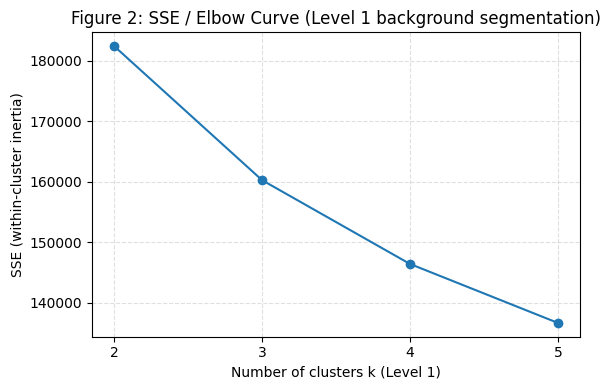

In [29]:
# Figure 2: SSE / Elbow Curve for Level 1

import matplotlib.pyplot as plt

# 取出不同 k 对应的 SSE（inertia）
ks = sorted(l1_inertias.keys())
sse_values = [l1_inertias[k] for k in ks]

plt.figure(figsize=(6, 4))
plt.plot(ks, sse_values, marker="o")
plt.xticks(ks)

plt.xlabel("Number of clusters k (Level 1)")
plt.ylabel("SSE (within-cluster inertia)")
plt.title("Figure 2: SSE / Elbow Curve (Level 1 background segmentation)")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


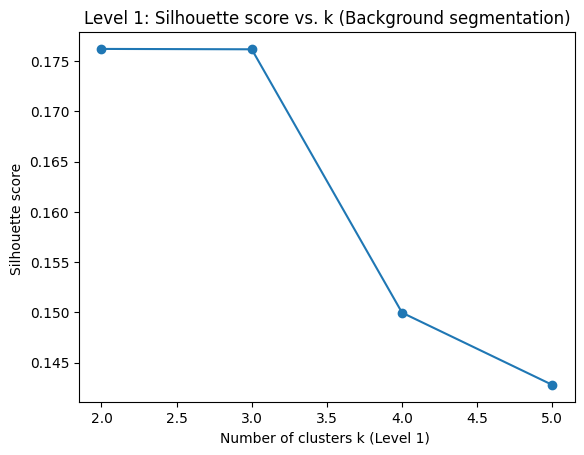

In [13]:
# 6.2 Plot silhouette scores for Level 1 / 可视化第一层 k 的选择
plt.figure()
plt.plot(list(l1_sil_scores.keys()), list(l1_sil_scores.values()), marker="o")
plt.xlabel("Number of clusters k (Level 1) ")
plt.ylabel("Silhouette score ")
plt.title("Level 1: Silhouette score vs. k (Background segmentation)")
plt.show()

In [14]:
# 6.3 Fit final Level 1 model with k=3 / 使用 k=3 拟合第一层聚类模型

l1_chosen_k = 3
l1_kmeans_final = KMeans(n_clusters=l1_chosen_k, random_state=42, n_init=10)

l1_final_model = Pipeline(steps=[("preprocessor", l1_preprocessor),
                                 ("cluster", l1_kmeans_final)])

l1_labels = l1_final_model.fit_predict(X_l1)

seg_df["segment_q1_l1"] = l1_labels
df["segment_q1_l1"] = l1_labels

print("Level 1 segment distribution / 第一层客群样本占比：")
print(df["segment_q1_l1"].value_counts(normalize=True).sort_index())

Level 1 segment distribution / 第一层客群样本占比：
segment_q1_l1
0    0.589480
1    0.030767
2    0.379753
Name: proportion, dtype: float64


In [15]:
# 6.4 Level 1 profiling / 第一层客群画像

def l1_normalized_crosstab(col):
    ct = pd.crosstab(df["segment_q1_l1"], df[col], normalize="index")
    return (ct * 100).round(1)

l1_num_profile = df.groupby("segment_q1_l1")[["age", "balance"]].agg(["mean", "median", "min", "max"]).round(1)
print("Level 1 numeric profile (age, balance) / 第一层数值画像（年龄、余额）：")
print(l1_num_profile)

print("\nJob profile by Level 1 segment / 第一层客群按职业分布：")
print(l1_normalized_crosstab("job"))

Level 1 numeric profile (age, balance) / 第一层数值画像（年龄、余额）：
                age                 balance                       
               mean median min max     mean   median   min     max
segment_q1_l1                                                     
0              33.8   34.0  18  47    862.3    369.0 -8019    8594
1              43.4   42.0  20  85  13691.8  10884.0  6961  102127
2              51.8   51.0  38  95   1139.5    515.0 -6847    9224

Job profile by Level 1 segment / 第一层客群按职业分布：
job            admin.  blue-collar  entrepreneur  housemaid  management  \
segment_q1_l1                                                             
0                12.9         22.1           2.9        1.5        21.2   
1                 8.1         13.8           4.1        2.7        33.1   
2                 9.4         21.2           3.8        4.6        19.4   

job            retired  self-employed  services  student  technician  \
segment_q1_l1                                  

In [16]:
print("\nEducation profile by Level 1 segment / 第一层客群按教育水平分布：")
print(l1_normalized_crosstab("education"))

print("\nMarital profile by Level 1 segment / 第一层客群按婚姻状况分布：")
print(l1_normalized_crosstab("marital"))

print("\nHousing loan profile by Level 1 segment / 第一层客群按房贷情况分布：")
print(l1_normalized_crosstab("housing"))

print("\nPersonal loan profile by Level 1 segment / 第一层客群按个人贷款情况分布：")
print(l1_normalized_crosstab("loan"))

print("\nDefault profile by Level 1 segment / 第一层客群按违约情况分布：")
print(l1_normalized_crosstab("default"))


Education profile by Level 1 segment / 第一层客群按教育水平分布：
education      primary  secondary  tertiary  unknown
segment_q1_l1                                       
0                  9.5       55.5      32.0      3.0
1                 12.4       36.9      46.0      4.7
2                 24.2       46.0      24.0      5.8

Marital profile by Level 1 segment / 第一层客群按婚姻状况分布：
marital        divorced  married  single
segment_q1_l1                           
0                   8.4     48.8    42.8
1                   8.6     65.6    25.9
2                  16.6     77.4     6.0

Housing loan profile by Level 1 segment / 第一层客群按房贷情况分布：
housing          no   yes
segment_q1_l1            
0              35.2  64.8
1              55.8  44.2
2              57.8  42.2

Personal loan profile by Level 1 segment / 第一层客群按个人贷款情况分布：
loan             no   yes
segment_q1_l1            
0              83.9  16.1
1              94.8   5.2
2              83.3  16.7

Default profile by Level 1 segment / 第一层客群按违约情

C:\Users\Icey\AppData\Local\Temp\ipykernel_21856\3429640686.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")  # 20 个高区分度颜色


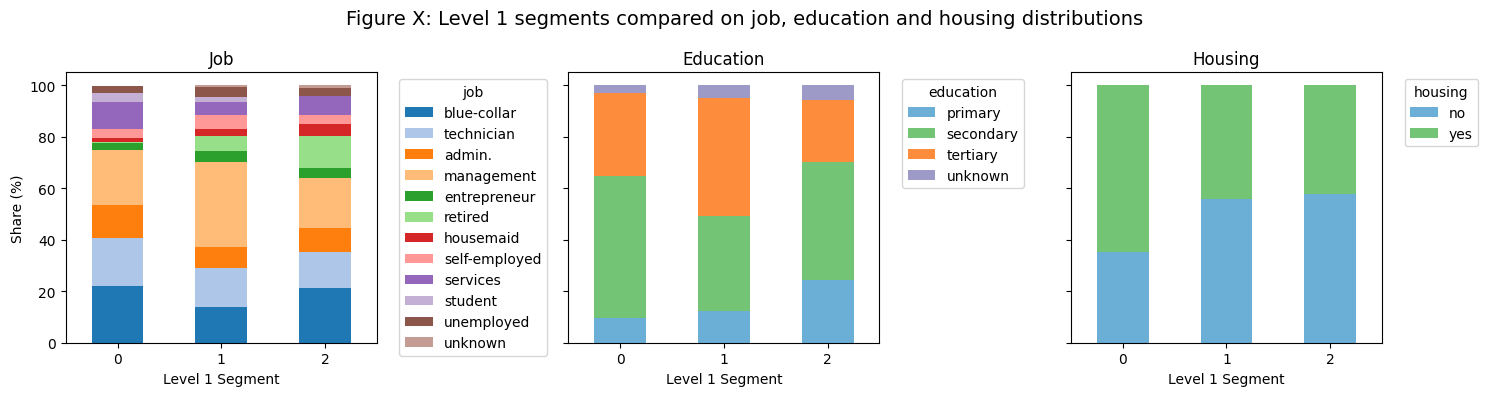

In [37]:
# Figure X (Improved Job Colors): Level 1 Segments on Job / Education / Housing

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ✅ 中等深度 muted palette（用于 education / housing）
deeper_colors = [
    "#6baed6", "#74c476", "#fd8d3c", "#9e9ac8", "#fdd0a2",
    "#a1d99b", "#9ecae1", "#fdae6b", "#bcbddc", "#c7e9c0"
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=deeper_colors)


# ✅ Job 图（单独使用 tab20，高区分度颜色）
def plot_segment_stacked_job(ax=None, title="Job"):
    ct = l1_normalized_crosstab("job")

    base_order = [
        "blue-collar",
        "technician",
        "admin.",
        "management",
        "entrepreneur",
        "retired"
    ]
    other_cols = [c for c in ct.columns if c not in base_order]
    ordered_cols = [c for c in base_order + other_cols if c in ct.columns]

    ct_ordered = ct[ordered_cols]

    if ax is None:
        ax = plt.gca()

    # 🔹 为每个职业生成一组明显不同的颜色
    cmap = cm.get_cmap("tab20")  # 20 个高区分度颜色
    job_colors = [cmap(i % cmap.N) for i in range(len(ordered_cols))]

    ct_ordered.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=job_colors  # ⬅️ 针对 job 显式指定颜色，避免太像
    )

    ax.set_xlabel("Level 1 Segment")
    ax.set_ylabel("Share (%)")
    ax.set_title(title)
    ax.legend(title="job", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=0)
    return ax


# ✅ 通用图：Education / Housing（继续用 muted 色系）
def plot_segment_stacked(col, ax=None, title=None):
    ct = l1_normalized_crosstab(col)

    if ax is None:
        ax = plt.gca()

    ct.plot(kind="bar", stacked=True, ax=ax)
    ax.set_xlabel("Level 1 Segment")
    ax.set_ylabel("Share (%)")
    ax.set_title(title if title else col)
    ax.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=0)
    return ax


# ✅ 三图并排输出
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

plot_segment_stacked_job(ax=axes[0], title="Job")
plot_segment_stacked("education", ax=axes[1], title="Education")
plot_segment_stacked("housing",   ax=axes[2], title="Housing")

fig.suptitle(
    "Figure X: Level 1 segments compared on job, education and housing distributions",
    fontsize=14
)

plt.tight_layout()
plt.show()


## 7. Level 2 clustering – Financial strength & campaign potential / 第二层聚类：财务实力 + 活动潜力

In [17]:
# 7.1 Define numeric and categorical columns for Level 2 / 定义第二层数值与分类变量

l2_num_cols = ["balance", "campaign", "pdays", "previous", "day"]
l2_num_cols = [c for c in l2_num_cols if c in l2_features]

l2_cat_cols = ["default", "housing", "loan", "contact", "month", "poutcome"]
l2_cat_cols = [c for c in l2_cat_cols if c in l2_features]

print("Level 2 numeric columns / 第二层数值变量：", l2_num_cols)
print("Level 2 categorical columns / 第二层分类型变量：", l2_cat_cols)

l2_numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
l2_categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

l2_preprocessor = ColumnTransformer(
    transformers=[
        ("num", l2_numeric_transformer, l2_num_cols),
        ("cat", l2_categorical_transformer, l2_cat_cols),
    ]
)

df["segment_q1_l2"] = np.nan

Level 2 numeric columns / 第二层数值变量： ['balance', 'campaign', 'pdays', 'previous', 'day']
Level 2 categorical columns / 第二层分类型变量： ['default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [38]:
# 7.1b Sanity check for Level 2 k choices
# 在对每个第一层客群做第二层聚类前，先比较不同 k 的轮廓系数，看看 k=2 是否合理

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

candidate_ks = [2, 3, 4, 5]  # 你可以按需调整候选 k / candidate k values
l2_sil_summary = {}          # 保存每个 Level 1 簇下，不同 k 的 silhouette / store results

for l1_seg in sorted(df["segment_q1_l1"].unique()):
    mask = df["segment_q1_l1"] == l1_seg
    df_sub = df.loc[mask, :].copy()
    X_l2 = df_sub[l2_features].copy()

    print(f"\n[Level 2] Searching k for Level-1 segment {l1_seg}")
    print(f"  Sample size / 样本量 = {df_sub.shape[0]}")

    l2_sil_summary[l1_seg] = {}

    for k in candidate_ks:
        # 样本数太少就跳过 / skip if too few rows
        if df_sub.shape[0] <= k:
            print(f"    - k={k}: skipped (n <= k)")
            continue

        kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
        model_tmp = Pipeline(
            steps=[("preprocessor", l2_preprocessor),
                   ("cluster", kmeans_tmp)]
        )

        labels = model_tmp.fit_predict(X_l2)
        X_l2_trans = model_tmp.named_steps["preprocessor"].transform(X_l2)
        sil = silhouette_score(X_l2_trans, labels)

        l2_sil_summary[l1_seg][k] = sil
        print(f"    - k = {k}, silhouette = {sil:.4f}")

# 可选：整理成一个 DataFrame 方便一眼对比 / optional: summary table
rows = []
for l1_seg, k_dict in l2_sil_summary.items():
    for k, sil in k_dict.items():
        rows.append({"Level1_segment": l1_seg, "k": k, "silhouette": sil})

l2_sil_df = pd.DataFrame(rows)
display(l2_sil_df.pivot(index="k", columns="Level1_segment", values="silhouette"))


# 整理成和截图一样的透视表结构
l2_sil_table = (
    l2_sil_df
        .pivot(index="Level1_segment",   # 行：Level1_segment
               columns="k",              # 列：k
               values="silhouette")
        .sort_index()
)

# 设置行列名称，显示成左侧 Level1_segment，上方 k
l2_sil_table.index.name = "Level1_segment"
l2_sil_table.columns.name = "k"

# 保留 6 位小数并输出
display(l2_sil_table.round(6))




[Level 2] Searching k for Level-1 segment 0
  Sample size / 样本量 = 26651
    - k = 2, silhouette = 0.3054
    - k = 3, silhouette = 0.1588
    - k = 4, silhouette = 0.1756
    - k = 5, silhouette = 0.1845

[Level 2] Searching k for Level-1 segment 1
  Sample size / 样本量 = 1391
    - k = 2, silhouette = 0.3108
    - k = 3, silhouette = 0.1788
    - k = 4, silhouette = 0.1778
    - k = 5, silhouette = 0.1923

[Level 2] Searching k for Level-1 segment 2
  Sample size / 样本量 = 17169
    - k = 2, silhouette = 0.3400
    - k = 3, silhouette = 0.1580
    - k = 4, silhouette = 0.1722
    - k = 5, silhouette = 0.1723


Level1_segment,0,1,2
k,,,
2,0.305446,0.310765,0.339960
3,0.158821,0.178846,0.158050
4,0.175614,0.177756,0.172152
5,0.184462,0.192349,0.172298


k,2,3,4,5
Level1_segment,,,,
0,0.305446,0.158821,0.175614,0.184462
1,0.310765,0.178846,0.177756,0.192349
2,0.339960,0.158050,0.172152,0.172298


In [19]:
# 7.2 Level 2 clustering with k=2 for each Level 1 segment / 每个第一层客群内使用 k=2 进行第二层聚类

l2_chosen_k = 2

for l1_seg in sorted(df["segment_q1_l1"].unique()):
    print(f"\n[Level 2] Processing Level 1 segment = {l1_seg}")
    
    mask = df["segment_q1_l1"] == l1_seg
    df_sub = df.loc[mask, :].copy()
    
    if df_sub.shape[0] <= l2_chosen_k:
        print(f"  - Segment {l1_seg} has only {df_sub.shape[0]} rows, skip.")
        continue
    
    X_l2 = df_sub[l2_features].copy()
    
    l2_kmeans = KMeans(n_clusters=l2_chosen_k, random_state=42, n_init=10)
    l2_model = Pipeline(steps=[("preprocessor", l2_preprocessor),
                               ("cluster", l2_kmeans)])
    
    l2_local_labels = l2_model.fit_predict(X_l2)
    
    X_l2_transformed = l2_model.named_steps["preprocessor"].transform(X_l2)
    sil_l2 = silhouette_score(X_l2_transformed, l2_local_labels)
    print(f"  - Sample size: {df_sub.shape[0]}, silhouette: {sil_l2:.4f}")
    
    l2_global_labels = l1_seg * 10 + l2_local_labels
    df.loc[mask, "segment_q1_l2"] = l2_global_labels

if not df["segment_q1_l2"].isna().any():
    df["segment_q1_l2"] = df["segment_q1_l2"].astype(int)

print("\nLevel 2 segment distribution / 第二层客群样本占比：")
print(df["segment_q1_l2"].value_counts(normalize=True).sort_index())


[Level 2] Processing Level 1 segment = 0
  - Sample size: 26651, silhouette: 0.3054

[Level 2] Processing Level 1 segment = 1
  - Sample size: 1391, silhouette: 0.3108

[Level 2] Processing Level 1 segment = 2
  - Sample size: 17169, silhouette: 0.3400

Level 2 segment distribution / 第二层客群样本占比：
segment_q1_l2
0     0.483577
1     0.105903
10    0.024529
11    0.006237
20    0.058105
21    0.321647
Name: proportion, dtype: float64


## 8. Cross sheet between Level 1 and Level 2 segments / 第一层与第二层客群交叉表

In [20]:
# 8.1 Cross sheet: counts / 交叉表（数量）
cross_counts = pd.crosstab(df["segment_q1_l1"], df["segment_q1_l2"])
print("Cross sheet (counts) / 第一层 × 第二层 客群交叉表（数量）：")
print(cross_counts)

Cross sheet (counts) / 第一层 × 第二层 客群交叉表（数量）：
segment_q1_l2     0     1     10   11    20     21
segment_q1_l1                                     
0              21863  4788     0    0     0      0
1                  0     0  1109  282     0      0
2                  0     0     0    0  2627  14542


In [21]:
# 8.2 Cross sheet: row-wise percentage / 交叉表（行百分比）
cross_pct = pd.crosstab(df["segment_q1_l1"], df["segment_q1_l2"], normalize="index").round(4) * 100
print("\nCross sheet (row-wise %) / 第一层 × 第二层 客群交叉表（行百分比）：")
print(cross_pct)


Cross sheet (row-wise %) / 第一层 × 第二层 客群交叉表（行百分比）：
segment_q1_l2     0      1      10     11    20    21
segment_q1_l1                                        
0              82.03  17.97   0.00   0.00   0.0   0.0
1               0.00   0.00  79.73  20.27   0.0   0.0
2               0.00   0.00   0.00   0.00  15.3  84.7


In [22]:
# 8.3 Save cross sheets / 保存交叉表
cross_counts_path = os.path.join(output_dir, "cross_segments_q1_counts.csv")
cross_pct_path = os.path.join(output_dir, "cross_segments_q1_percentage.csv")

cross_counts.to_csv(cross_counts_path)
cross_pct.to_csv(cross_pct_path)

print("Saved cross sheet (counts) / 已保存交叉表（数量）：", cross_counts_path)
print("Saved cross sheet (percentage) / 已保存交叉表（行百分比）：", cross_pct_path)

Saved cross sheet (counts) / 已保存交叉表（数量）： D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output\cross_segments_q1_counts.csv
Saved cross sheet (percentage) / 已保存交叉表（行百分比）： D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output\cross_segments_q1_percentage.csv


## 9. Level 2 profiling / 第二层客群画像

In [23]:
# 9.1 Financial profile by Level 2 / 第二层财务画像
l2_fin_profile = df.groupby("segment_q1_l2")[["balance"]].agg(["mean", "median", "min", "max"]).round(1)
print("Level 2 financial profile (balance) / 第二层财务画像（余额）：")
print(l2_fin_profile)

Level 2 financial profile (balance) / 第二层财务画像（余额）：
               balance                       
                  mean   median   min     max
segment_q1_l2                                
0                822.0    341.0 -8019    8594
1               1045.9    500.0 -1884    7944
10             13868.4  10957.0  6961  102127
11             12997.5  10570.5  7154   81204
20              1353.0    723.0 -1621    8603
21              1100.9    484.0 -6847    9224


In [24]:
# 9.2 Campaign-related profiles / 营销联络特征画像
def l2_normalized_crosstab(col):
    ct = pd.crosstab(df["segment_q1_l2"], df[col], normalize="index")
    return (ct * 100).round(1)

if "poutcome" in df.columns:
    print("\nLevel 2 profile by poutcome / 第二层客群按 poutcome 分布：")
    print(l2_normalized_crosstab("poutcome"))

if "contact" in df.columns:
    print("\nLevel 2 profile by contact / 第二层客群按 contact 分布：")
    print(l2_normalized_crosstab("contact"))

if "month" in df.columns:
    print("\nLevel 2 profile by month / 第二层客群按 month 分布：")
    print(l2_normalized_crosstab("month"))


Level 2 profile by poutcome / 第二层客群按 poutcome 分布：
poutcome       failure  other  success  unknown
segment_q1_l2                                  
0                  0.4    0.4      0.7     98.4
1                 62.7   23.1     14.0      0.1
10                 0.5    0.1      0.2     99.3
11                54.6   23.8     21.6      0.0
20                61.2   18.7     20.0      0.0
21                 0.3    0.5      0.6     98.6

Level 2 profile by contact / 第二层客群按 contact 分布：
contact        cellular  telephone  unknown
segment_q1_l2                              
0                  60.7        3.8     35.5
1                  94.6        4.5      0.9
10                 62.9        8.0     29.0
11                 90.8        7.8      1.4
20                 86.3       12.9      0.8
21                 56.8        9.7     33.5

Level 2 profile by month / 第二层客群按 month 分布：
month           apr   aug  dec   feb  jan   jul   jun  mar   may   nov  oct  \
segment_q1_l2                           

## 10. Optional: PCA visualisation / 可选：PCA 可视化

C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170:

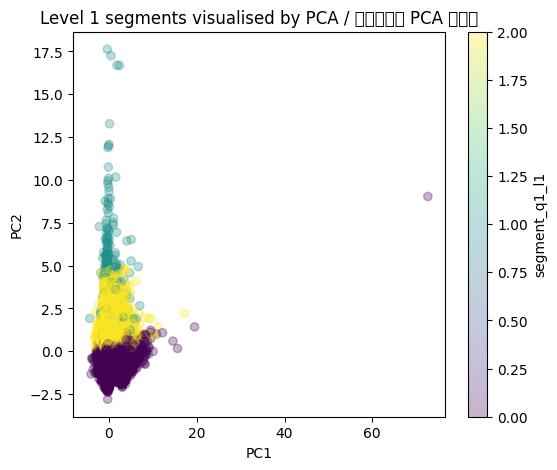

C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


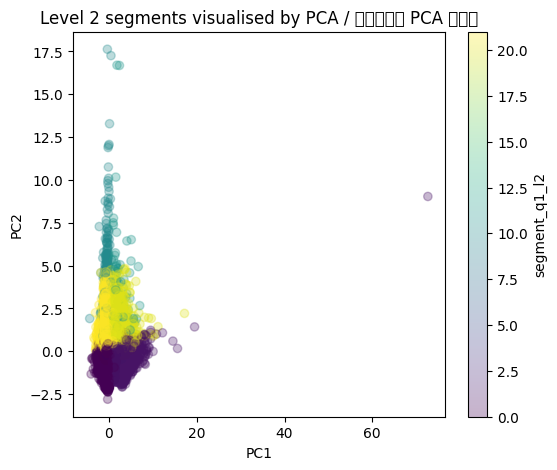

In [25]:
# 10. PCA visualisation for Level 1 & Level 2 / 使用 PCA 对两层客群进行可视化

seg_df_nodup = seg_df.loc[:, ~seg_df.columns.duplicated()].copy()

all_features = [
    "age", "job", "marital", "education",
    "balance", "housing", "loan", "default",
    "campaign", "pdays", "previous", "poutcome", "contact", "month", "day"
]
all_features = [c for c in all_features if c in seg_df_nodup.columns]

X_all = seg_df_nodup[all_features].copy()

num_cols_all = [c for c in ["age", "balance", "campaign", "pdays", "previous", "day"] if c in X_all.columns]
cat_cols_all = [c for c in ["job", "marital", "education", "housing", "loan", "default", "contact", "month", "poutcome"] if c in X_all.columns]

numeric_tf_all = Pipeline([("scaler", StandardScaler())])
categorical_tf_all = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor_all = ColumnTransformer(
    transformers=[
        ("num", numeric_tf_all, num_cols_all),
        ("cat", categorical_tf_all, cat_cols_all),
    ]
)

X_all_transformed = preprocessor_all.fit_transform(X_all)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all_transformed)

plt.figure(figsize=(6, 5))
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["segment_q1_l1"], alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Level 1 segments visualised by PCA / 第一层客群 PCA 可视化")
plt.colorbar(scatter1, label="segment_q1_l1")
plt.show()

plt.figure(figsize=(6, 5))
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["segment_q1_l2"], alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Level 2 segments visualised by PCA / 第二层客群 PCA 可视化")
plt.colorbar(scatter2, label="segment_q1_l2")
plt.show()

## 11. Save final outputs / 保存最终输出文件

In [26]:
# 11. Save final outputs / 保存最终输出

output_path_full = os.path.join(output_dir, "bank_with_segments_q1_twolevel_bg_campaign.csv")
df.to_csv(output_path_full, index=False)
print("Saved full dataset with segments / 已保存完整带客群标签数据:", output_path_full)

seg_output_path = os.path.join(output_dir, "bank_segmentation_q1_twolevel_bg_campaign_only.csv")
seg_cols_to_save = ["customer_id"] + l1_features + l2_features + ["segment_q1_l1", "segment_q1_l2"]
seg_df_to_save = df[seg_cols_to_save].copy()
seg_df_to_save.to_csv(seg_output_path, index=False)
print("Saved Q1 segmentation-only file / 已保存 Q1 细分结果表:", seg_output_path)

Saved full dataset with segments / 已保存完整带客群标签数据: D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output\bank_with_segments_q1_twolevel_bg_campaign.csv
Saved Q1 segmentation-only file / 已保存 Q1 细分结果表: D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\output\bank_segmentation_q1_twolevel_bg_campaign_only.csv


=== 12.1 Silhouette score for final K-means models / 最终模型的轮廓系数 ===
[Level 1] silhouette score (k=3): 0.1762
[Level 2] Level1 segment = 0, silhouette (k=2) = 0.3054
[Level 2] Level1 segment = 1, silhouette (k=2) = 0.3108
[Level 2] Level1 segment = 2, silhouette (k=2) = 0.3400

=== 12.2 Stability check for Level 1 (multiple random states) / 第一层多随机种子稳定性检查 ===
Level 1 stability summary (cluster shares in %): / 第一层稳定性汇总（各簇占比，单位 %）


,random_state,silhouette,cluster_0_share,cluster_1_share,cluster_2_share
0,0,0.176176,37.97,58.95,3.08
1,10,0.176171,37.97,58.96,3.07
2,42,0.176173,58.95,3.08,37.98
3,99,0.176173,3.08,37.98,58.95



=== 12.3 Business separation: subscription rate & balance by segments / 不同客群在订阅率与余额上的差异 ===
Level 1 – subscription & balance profile / 第一层客群的订阅率与余额画像：


,segment_q1_l1,subscription_rate,avg_balance,median_balance,count,subscription_rate_percent
0,0,0.115718,862.3,369.0,26651,11.57
1,1,0.148814,13691.8,10884.0,1391,14.88
2,2,0.116373,1139.5,515.0,17169,11.64



Level 2 – subscription & balance profile / 第二层客群的订阅率与余额画像：


,segment_q1_l2,subscription_rate,avg_balance,median_balance,count,subscription_rate_percent
0,0,0.097516,822.0,341.0,21863,9.75
1,1,0.198830,1045.9,500.0,4788,19.88
2,10,0.112714,13868.4,10957.0,1109,11.27
3,11,0.290780,12997.5,10570.5,282,29.08
4,20,0.250476,1353.0,723.0,2627,25.05
5,21,0.092147,1100.9,484.0,14542,9.21



=== 12.4 Visualisations: subscription rate by segment / 订阅率对比图 ===


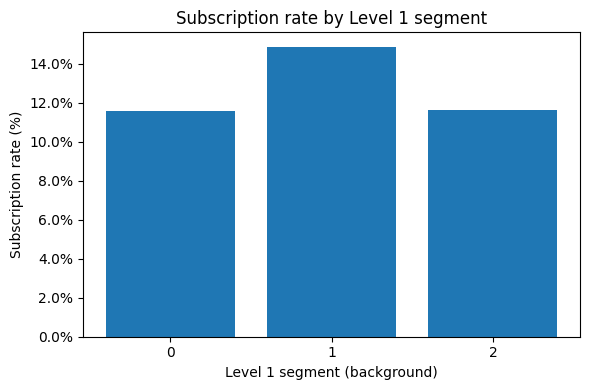

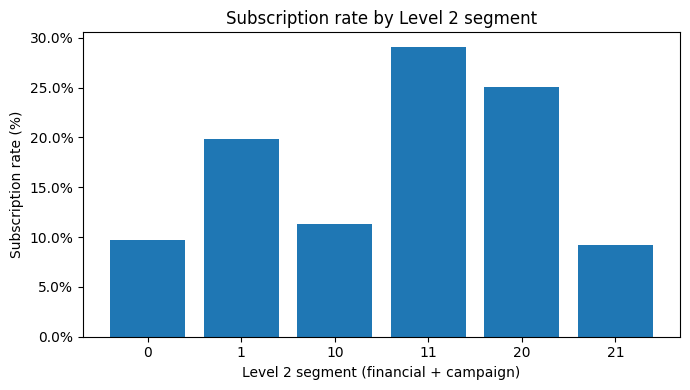


>>> 小结 / Summary：
1) Silhouette scores tell us whether the chosen k has reasonable internal structure.
   轮廓系数反映当前 k 下簇结构是否合理。
2) Stability table shows cluster shares are stable across different random seeds.
   稳定性表显示在不同随机种子下，各簇占比变化不大，说明结果鲁棒。
3) Business tables & plots show subscription rate and balance differ by segments.
   业务画像表和图说明，不同客群在订阅率和余额上存在显著差异，说明细分对业务有用。


In [27]:
# ============================================================
# 12. K-means validation checklist / K-means 聚类效果验证清单
# 该部分用于从：内部质量、稳定性、业务区分度三个角度检查聚类结果
# 前提：本 Notebook 中已经完成 Q1 两层聚类，并生成：
#   - df["segment_q1_l1"], df["segment_q1_l2"]
#   - l1_features, l1_preprocessor, l1_chosen_k
#   - l2_features, l2_preprocessor
# ============================================================

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ---------- 12.1 Internal quality: silhouette for chosen k ----------
# ---------- 12.1 内部聚类质量：当前 k 值下的轮廓系数 ----------

print("=== 12.1 Silhouette score for final K-means models / 最终模型的轮廓系数 ===")

# Level 1: use background features / 第一层：用背景特征（人口 + 财务）
X_l1_valid = seg_df[l1_features].copy()
X_l1_trans_valid = l1_preprocessor.fit_transform(X_l1_valid)

l1_labels_final = df["segment_q1_l1"].values
sil_l1_final = silhouette_score(X_l1_trans_valid, l1_labels_final)
print(f"[Level 1] silhouette score (k={l1_chosen_k}): {sil_l1_final:.4f}")

# Level 2: per Level 1 segment / 第二层：在每个第一层客群内部计算轮廓系数
l2_sil_per_l1 = {}

for l1_seg in sorted(df["segment_q1_l1"].unique()):
    mask = df["segment_q1_l1"] == l1_seg
    df_sub = df.loc[mask, :].copy()
    
    # 如果这一类样本太少，就跳过
    if df_sub.shape[0] <= 2:
        continue
    
    # 取第二层聚类用到的特征 / use Level 2 features
    X_l2_sub = df_sub[l2_features].copy()
    
    # 重新做一次预处理 + silhouette（不改变原有结果，只是计算指标）
    l2_model_for_sil = Pipeline(
        steps=[
            ("preprocessor", l2_preprocessor),
        ]
    )
    X_l2_trans = l2_model_for_sil.fit_transform(X_l2_sub)
    
    # 还原局部第二层标签（global_id = l1_seg*10 + local_id）
    # local_id = global_id - l1_seg*10
    l2_global_labels = df_sub["segment_q1_l2"].values
    l2_local_labels = l2_global_labels - l1_seg * 10
    
    sil_l2 = silhouette_score(X_l2_trans, l2_local_labels)
    l2_sil_per_l1[l1_seg] = sil_l2
    print(f"[Level 2] Level1 segment = {l1_seg}, silhouette (k=2) = {sil_l2:.4f}")

# ---------- 12.2 Stability check (Level 1 only) ----------
# ---------- 12.2 模型稳定性检查（以第一层为例） ----------

print("\n=== 12.2 Stability check for Level 1 (multiple random states) / 第一层多随机种子稳定性检查 ===")

random_states = [0, 10, 42, 99]
stability_records = []

for rs in random_states:
    kmeans_tmp = KMeans(n_clusters=l1_chosen_k, random_state=rs, n_init=10)
    model_tmp = Pipeline(
        steps=[
            ("preprocessor", l1_preprocessor),
            ("cluster", kmeans_tmp),
        ]
    )
    
    labels_tmp = model_tmp.fit_predict(X_l1_valid)
    X_l1_tmp = model_tmp.named_steps["preprocessor"].transform(X_l1_valid)
    sil_tmp = silhouette_score(X_l1_tmp, labels_tmp)
    
    # 计算各簇占比 / cluster size distribution
    size_dist = pd.Series(labels_tmp).value_counts(normalize=True).sort_index()
    record = {"random_state": rs, "silhouette": sil_tmp}
    for cid, pct in size_dist.items():
        record[f"cluster_{cid}_share"] = round(pct * 100, 2)
    stability_records.append(record)

stability_df = pd.DataFrame(stability_records)
print("Level 1 stability summary (cluster shares in %): / 第一层稳定性汇总（各簇占比，单位 %）")
display(stability_df)

# ---------- 12.3 Business separation: y & balance by segment ----------
# ---------- 12.3 业务区分度：不同客群在订阅率与余额上的差异 ----------

print("\n=== 12.3 Business separation: subscription rate & balance by segments / 不同客群在订阅率与余额上的差异 ===")

# Level 1: subscription rate & average balance / 第一层：订阅率与平均余额
l1_business = df.groupby("segment_q1_l1").agg(
    subscription_rate=("y", lambda s: (s == "yes").mean()),
    avg_balance=("balance", "mean"),
    median_balance=("balance", "median"),
    count=("y", "size")
).reset_index()
l1_business["subscription_rate_percent"] = (l1_business["subscription_rate"] * 100).round(2)
l1_business["avg_balance"] = l1_business["avg_balance"].round(1)
l1_business["median_balance"] = l1_business["median_balance"].round(1)

print("Level 1 – subscription & balance profile / 第一层客群的订阅率与余额画像：")
display(l1_business)

# Level 2: subscription rate & average balance / 第二层：订阅率与平均余额
l2_business = df.groupby("segment_q1_l2").agg(
    subscription_rate=("y", lambda s: (s == "yes").mean()),
    avg_balance=("balance", "mean"),
    median_balance=("balance", "median"),
    count=("y", "size")
).reset_index()
l2_business["subscription_rate_percent"] = (l2_business["subscription_rate"] * 100).round(2)
l2_business["avg_balance"] = l2_business["avg_balance"].round(1)
l2_business["median_balance"] = l2_business["median_balance"].round(1)

print("\nLevel 2 – subscription & balance profile / 第二层客群的订阅率与余额画像：")
display(l2_business)

# ---------- 12.4 Simple visualisations for report ----------
# ---------- 12.4 可用于报告的简单可视化图 ----------

print("\n=== 12.4 Visualisations: subscription rate by segment / 订阅率对比图 ===")

# Level 1 – subscription rate bar chart / 第一层订阅率柱状图
plt.figure(figsize=(6,4))
plt.bar(l1_business["segment_q1_l1"].astype(str), l1_business["subscription_rate_percent"])
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.xlabel("Level 1 segment (background)")
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by Level 1 segment")
plt.tight_layout()
plt.show()

# Level 2 – subscription rate bar chart / 第二层订阅率柱状图
plt.figure(figsize=(7,4))
plt.bar(l2_business["segment_q1_l2"].astype(str), l2_business["subscription_rate_percent"])
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.xlabel("Level 2 segment (financial + campaign)")
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by Level 2 segment")
plt.tight_layout()
plt.show()

print("\n>>> 小结 / Summary：")
print("1) Silhouette scores tell us whether the chosen k has reasonable internal structure.")
print("   轮廓系数反映当前 k 下簇结构是否合理。")
print("2) Stability table shows cluster shares are stable across different random seeds.")
print("   稳定性表显示在不同随机种子下，各簇占比变化不大，说明结果鲁棒。")
print("3) Business tables & plots show subscription rate and balance differ by segments.")
print("   业务画像表和图说明，不同客群在订阅率和余额上存在显著差异，说明细分对业务有用。")


Total samples for Level 1: 45211
Samples used for dendrogram: 1000


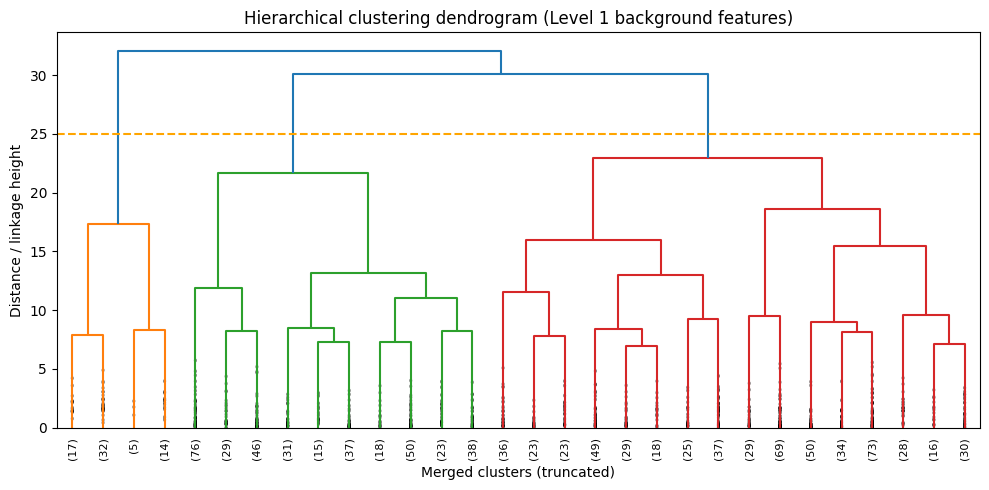

说明 / Notes:
- 树的纵轴越高，表示合并两个簇时的“距离”越大（越不像）。
- 在某个高度画一条水平线，对应截断树状图，可以看到大致会被切成多少个簇。
- 如果在接近 3 个簇的位置附近，树状图出现较自然的断层，则说明 k=3 的选择在层次结构上也是合理的。


In [28]:
# ============================================================
# 13. Hierarchical clustering + dendrogram for Level 1
# 13. 第一层层次聚类 + 树状图 (dendrogram) 可视化
#
# 目的 / Purpose：
# - 使用与 Level 1 相同的背景特征 (l1_features)，做一版层次聚类
# - 画出 dendrogram，观察在 k=3 左右是否有自然的“断层”
# - 作为 K-means(k=3) 选择的一个 sanity check / 佐证
#
# 前提 / Prerequisites：
# - 本 Notebook 中已经定义了：seg_df, l1_features, l1_preprocessor
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.sparse import issparse

# 13.1 准备数据：使用 Level 1 的背景特征 / Prepare data using Level 1 background features
X_l1_full = seg_df[l1_features].copy()

# 使用与 K-means 相同的预处理（标准化 + one-hot） / 
# Use the same preprocessing as Level 1 K-means
X_l1_pre = l1_preprocessor.fit_transform(X_l1_full)

# 将稀疏矩阵转成稠密数组，便于计算层次聚类 / Convert sparse matrix to dense array if needed
if issparse(X_l1_pre):
    X_l1_pre_dense = X_l1_pre.toarray()
else:
    X_l1_pre_dense = np.asarray(X_l1_pre)

n_samples = X_l1_pre_dense.shape[0]

# 为了让 dendrogram 更清晰，我们仅从全体客户中抽样最多 1000 个样本做树状图
# To keep the dendrogram readable, we sample at most 1,000 customers
max_samples_for_dendro = 1000
sample_size = min(max_samples_for_dendro, n_samples)

rng = np.random.RandomState(42)
sample_indices = rng.choice(n_samples, size=sample_size, replace=False)

X_sample = X_l1_pre_dense[sample_indices, :]

print(f"Total samples for Level 1: {n_samples}")
print(f"Samples used for dendrogram: {sample_size}")

# 13.2 计算层次聚类的 linkage 矩阵
# method='ward' 适用于欧式距离，倾向于发现“球状”簇
# Compute linkage matrix for hierarchical clustering
Z = linkage(X_sample, method="ward")

# 13.3 画 dendrogram 树状图
plt.figure(figsize=(10, 5))

# truncate_mode='lastp' 可以只显示最后 p 个聚类分支，让图更简洁
# truncate_mode='lastp' shows only the last p merged clusters for clarity
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    color_threshold=25   # ✅ 强制在高度 25 切成 3 簇
)


plt.xlabel("Merged clusters (truncated)")
plt.ylabel("Distance / linkage height")
plt.title("Hierarchical clustering dendrogram (Level 1 background features)")

# 你可以尝试在某个高度画一条水平线，观察对应切分大概是几类
# You may add a horizontal line at a certain height to inspect a k-cluster cut
# 例如：plt.axhline(y=20, color='red', linestyle='--')  # 20 这个值需根据图形实际调整
# Example:
plt.axhline(y=25, color='orange', linestyle='--')

plt.tight_layout()
plt.show()

print(
    "说明 / Notes:\n"
    "- 树的纵轴越高，表示合并两个簇时的“距离”越大（越不像）。\n"
    "- 在某个高度画一条水平线，对应截断树状图，可以看到大致会被切成多少个簇。\n"
    "- 如果在接近 3 个簇的位置附近，树状图出现较自然的断层，则说明 k=3 的选择在层次结构上也是合理的。"
)
